In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(ts[0].shape)

(830, 264, 124)


In [63]:
import itertools
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.nt = np.array(nt)
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, np.sum(nt)).float().cuda())

    def forward(self, sub, book, mod):
        nt = self.nt[mod]
        start = 0 if mod == 0 else np.sum(self.nt[:mod])
        end = start+nt
        w = self.w[sub,:,start:end]
        return torch.einsum('pt,pab->abt', F.leaky_relu(w), book)

def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_mag_loss(lrc):
    loss = [torch.mean((A-0.01)**2) for A in lrc.As]
    return sum(loss)/len(loss)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

mseLoss = nn.MSELoss()

mod = 'emoid'
modidx = 2
modidx2 = 2

# Timeseries
# x = torch.from_numpy(ts[modidx]).float().cuda()
# x2 = torch.from_numpy(ts[modidx2]).float().cuda()
xs = [torch.from_numpy(ts[idx]).float().cuda() for idx in range(2,3)]
x2 = torch.cat([torch.from_numpy(ts[idx]) for idx in range(2,3)], dim=-1).float().cuda()
xts = [ts.shape[-1] for ts in xs]

# Parameters
ntrain = 500
nbatch = 30
smooth_mult = 0.1 #0.1
# mag_mult = 1e-4
nEpochs = 40
pPeriod = 5
ncodes = 400

print(f'Starting ncodes {ncodes}')
suborder = np.arange(xs[0].shape[0]) #x.shape[0]
np.random.shuffle(suborder)
suborder = suborder[:ntrain]

# Codebook and weights
lrc = LowRankCodes(ncodes*[1])
lrw = LowRankWeights(ntrain, ncodes, xts) #x.shape[-1]

# Optimizers
optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)

t0 = time.time()

for epoch in range(nEpochs):
    for bstart in range(0,ntrain,nbatch):
        for modidx in range(len(xts)):
            bend = bstart+nbatch
            if bend > ntrain:
                bend = ntrain
            optim.zero_grad()
            book = lrc()
            recon_loss = 0
            smooth_loss_fc = 0
            for subidx in range(bstart, bend):
                # THE FOLLOWING 3 LINES MEAN LRW.W DOESN'T MATCH SUBJECTS UNLESS WE MAP THROUGH SUBORDER
                # WHICH IS OKAY SINCE WE RE-ESTIMATE WEIGHTS THROUGH THE DICTIONARY ANYWAY
                # Note: suborder is constant for each run
                sub = suborder[subidx]
                xsub = get_sub_fc(xs[modidx][sub])
                xhat = lrw(subidx, book, modidx)   
                recon_loss += get_recon_loss(xsub, xhat)
                smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
            recon_loss /= (bend-bstart)
            smooth_loss_fc /= (bend-bstart)
    #         mag_loss = mag_mult*get_mag_loss(lrc)
            totloss = recon_loss+smooth_loss_fc
            totloss.backward()
            optim.step()
            sched.step(totloss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc]]} '
              f'lr: {sched._last_lr}')

t1 = time.time()
print(f'Completed dictionary estimation {t1-t0} sec')

# Weight estimation
book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0)
AA = A.T@A
codes = []

for sub in range(x2.shape[0]):
    B = get_sub_fc(x2[sub]).reshape(-1, x2.shape[-1])
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')

codes = torch.stack(codes)
print(codes.shape)
print('Finished weight estimation')

Starting ncodes 400
0 480 recon: [0.008721582243859497, 2.8455298978010615e-06] lr: [0.01]
5 480 recon: [0.0074404139773137515, 0.0012727332666107323] lr: [0.01]
10 480 recon: [0.006958346086778626, 0.0014849585732055633] lr: [0.00421875]
15 480 recon: [0.006677658617066759, 0.0015017790042898735] lr: [0.00421875]
20 480 recon: [0.006482532822843908, 0.0015775510785666883] lr: [0.00421875]
25 480 recon: [0.006341341607651954, 0.0016327958485180486] lr: [0.00421875]
30 480 recon: [0.006236106909236446, 0.0016664902018799282] lr: [0.00421875]
35 480 recon: [0.006151361980801662, 0.0016928305414281707] lr: [0.00421875]
39 480 recon: [0.006093606952427171, 0.0017115075274718892] lr: [0.00421875]
Completed dictionary estimation 459.04243683815 sec
Finished 0 0.004238269757479429
Finished 100 0.0061166551895439625
Finished 200 0.0042695351876318455
Finished 300 0.004820039961487055
Finished 400 0.006655964534729719
Finished 500 0.004951896145939827
Finished 600 0.0045080664567649364
Finished

In [64]:
# Nonneg Elastic Leastsquares

class ElasticNet(nn.Module):
    def __init__(self, AA, AB, l1, l2):
        super(ElasticNet, self).__init__()
        self.AA = AA
        self.AB = AB
        self.w = nn.Parameter(torch.rand(AB.shape[0],AA.shape[1],AB.shape[-1]).float().cuda())
        self.l1 = l1
        self.l2 = l2
        
    def train(self, lr=1e-1, nepochs=2000, pperiod=100, verbose=True):
        mseLoss = nn.MSELoss()
        optim = torch.optim.Adam([self.w], lr=lr, weight_decay=self.l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        for epoch in range(nepochs):
            optim.zero_grad()
            ABhat = torch.matmul(self.AA.detach(),F.leaky_relu(self.w))
            loss = mseLoss(ABhat, self.AB.detach())**0.5
            l1loss = self.l1*torch.mean(torch.abs(self.w))
            totloss = loss+l1loss
            totloss.backward()
            optim.step()
            sched.step(totloss)
            if not verbose:
                continue
            if epoch % pperiod == 0 or epoch == nepochs-1:
                print(f'{epoch} {[float(ls) for ls in [loss, l1loss]]} {sched._last_lr}')
        if verbose:
            print('Complete')

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0).detach()
AA = A.T@A
AB = []

for sub in range(x2.shape[0]):
    B = get_sub_fc(x2[sub]).reshape(-1, x2.shape[-1])
    AB.append(A.T@B)

AB = torch.stack(AB)
net = ElasticNet(AA.unsqueeze(0), AB, 0, 1e-5)
net.train(nepochs=600, lr=1e-1)

0 [197.42510986328125, 0.0] [0.1]
100 [0.3028956949710846, 0.0] [0.07500000000000001]
200 [0.19837430119514465, 0.0] [0.0421875]
300 [0.17167094349861145, 0.0] [0.0177978515625]
400 [0.16730917990207672, 0.0] [0.013348388671875001]
500 [0.1662176549434662, 0.0] [0.01001129150390625]
599 [0.1657521277666092, 0.0] [0.007508468627929688]
Complete


/tmp/ipykernel_18528/278696337.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


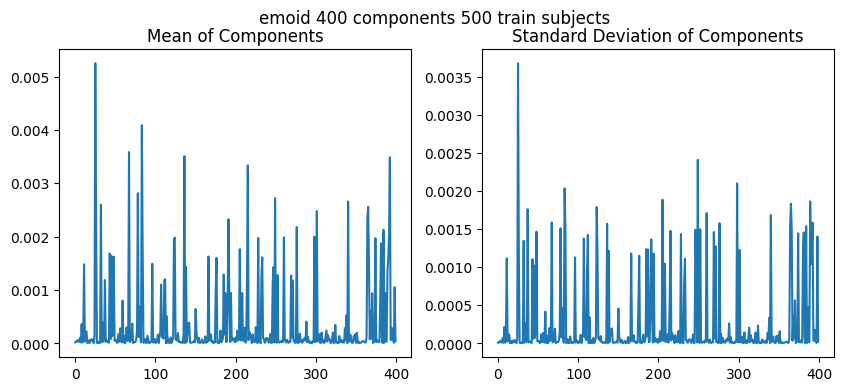

In [65]:
import matplotlib.pyplot as plt

# codes OR F.leaky_relu(net.w)
codesmu = F.leaky_relu(net.w)
codesmu = torch.mean(codesmu, dim=-1)
codesnp = codesmu.detach().cpu().numpy()
codesmumin,_ = torch.min(codesmu, dim=0)
codesmumax,_ = torch.max(codesmu, dim=0)
codesmumu = torch.mean(codesmu, dim=0)
codesmusigma = torch.std(codesmu, dim=0)
a = codesmumu.detach().cpu().numpy()
b = codesmusigma.detach().cpu().numpy()
c = codesmumin.detach().cpu().numpy()
d = codesmumax.detach().cpu().numpy()
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(a)
ax[0].set_title('Mean of Components')
# ax[0].plot(c)
# ax[0].plot(d)
ax[1].plot(b)
ax[1].set_title('Standard Deviation of Components')
fig.suptitle(f'{mod} {ncodes} components {ntrain} train subjects')
fig.show()

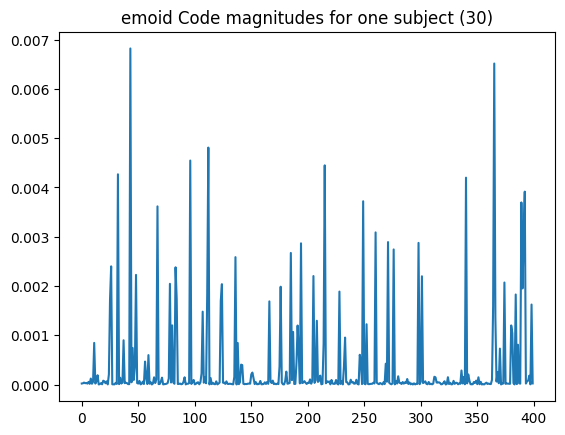

In [66]:
plt.plot(codesmu[30].detach().cpu().numpy())
plt.title(f'{mod} Code magnitudes for one subject (30)')
plt.show()

In [67]:
codesmumu = torch.einsum('abc,b->ab',F.relu(net.w.detach().cpu()),torch.mean(torch.abs(book.detach().cpu()), dim=(1,2)))
# codesmumu = torch.einsum('abc,b->ab',codes,torch.mean(torch.abs(book.detach().cpu()), dim=(1,2)))
codesmumu = torch.mean(torch.abs(codesmumu), dim=0)
idcs2 = torch.argsort(codesmumu)
# print(idcs2[:5])
print(idcs2[-5:])
# print([float(corr[idcs2[n]]) for n in range(5)])
print([float(corr[idcs2[-n]]) for n in range(5,0,-1)])
# print([np.mean(np.abs(codesnp[:,idcs2[n]])) for n  in range(5)])
print([np.mean(np.abs(codesnp[:,idcs2[-n]])) for n  in range(5,0,-1)])

tensor([ 78, 249, 340, 136, 215])
[-0.016519460827112198, -0.0051101320423185825, 0.01166500523686409, -0.015464733354747295, -0.012757940217852592]
[0.0028133579, 0.0027215476, 0.0026577392, 0.00350914, 0.0033354678]


In [77]:
def znorm(x):
    x = x-torch.mean(x, dim=-1, keepdims=True)
    x = x/torch.std(x, dim=-1, keepdims=True)
    return x

def getcorr(x,y):
    if len(y.shape) == 2:
        y = torch.argmax(y, dim=1).float()
    x = x-torch.mean(x,dim=0).unsqueeze(0)
    y = y-torch.mean(y)
    xy = torch.einsum('nd,n->d',x,y)
    xx = torch.einsum('nd,nd->d',x,x)
    yy = torch.sum(y*y)
    return xy/(xx*yy)**0.5

field = 'sex'
y = get_y(metadict, [field], subs)[0]
yt = torch.from_numpy(y).float()
xt = codesmu.cpu()
allidcs = []
greedyp = []
greedyn = []
greedycp = []
greedycn = []
for i in range(5):
    corr = getcorr(xt,yt)
    idcs = torch.argsort(corr)
    idcs = idcs[codesmumu[idcs] > 0.1*codesmumu[idcs2[-1]]]
    for i in range(50):
        nidx = idcs[i]
        if nidx not in allidcs:
            allidcs.append(nidx)
            break
    for i in range(50):
        pidx = idcs[-i-1]
        if pidx not in allidcs:
            allidcs.append(pidx)
            break
    greedyn.append(nidx)
    greedyp.append(pidx)
    greedycn.append(corr[nidx])
    greedycp.append(corr[pidx])
    print(corr[nidx])
    print(corr[pidx])
    print(allidcs)
    xcode = xt[:,torch.Tensor(allidcs).long()]
    w,_,_,_ = torch.linalg.lstsq(xt, yt)
    yp = xt@w
#     print(yt)
    yt = yt-yp
print(greedyn)
print(greedyp)
print(yt)
# print(corr[idcs[0]])
# print(corr[idcs[-1]])
# print(corr.shape)
# print(max(corr))
# print(min(corr))

tensor(-0.1794, grad_fn=<SelectBackward0>)
tensor(0.1916, grad_fn=<SelectBackward0>)
[tensor(374), tensor(25)]
tensor(-0.1600, grad_fn=<SelectBackward0>)
tensor(0.1205, grad_fn=<SelectBackward0>)
[tensor(374), tensor(25), tensor(194), tensor(276)]
tensor(-0.1495, grad_fn=<SelectBackward0>)
tensor(0.1074, grad_fn=<SelectBackward0>)
[tensor(374), tensor(25), tensor(194), tensor(276), tensor(138), tensor(392)]
tensor(-0.1336, grad_fn=<SelectBackward0>)
tensor(0.0796, grad_fn=<SelectBackward0>)
[tensor(374), tensor(25), tensor(194), tensor(276), tensor(138), tensor(392), tensor(215), tensor(205)]
tensor(-0.1274, grad_fn=<SelectBackward0>)
tensor(0.0703, grad_fn=<SelectBackward0>)
[tensor(374), tensor(25), tensor(194), tensor(276), tensor(138), tensor(392), tensor(215), tensor(205), tensor(340), tensor(233)]
[tensor(374), tensor(194), tensor(138), tensor(215), tensor(340)]
[tensor(25), tensor(276), tensor(392), tensor(205), tensor(233)]
tensor([[ 0.7103, -0.7359],
        [ 1.0756, -0.8709]

In [78]:
roimap = '''
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
255
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
137
139
133
134
135
136
221
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
222
223
224
225
226
227
228
229
230
231
232
233
234
138
235
236
237
238
239
240
241
242
251
252
256
257
258
259
260
261
262
263
264
243
244
245
246
1
2
3
4
5
6
7
8
9
10
11
12
84
85
132
140
141
142
182
183
184
185
247
248
249
250
253
254
'''

roimap = [int(roi)-1 for roi in roimap.split()]
print(roimap)

def remap(fc, roimap=roimap):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 137, 234, 235, 236, 237, 

In [79]:
comm_map = '''
14
14
14
14
14
14
14
14
14
14
14
14
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
14
14
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
14
6
6
6
6
5
11
5
14
14
14
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
14
14
14
14
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
6
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
13
13
13
13
14
14
14
14
12
12
14
14
1
12
12
12
12
12
12
12
12
12
'''

comm_map = [int(comm)-1 for comm in comm_map.split()]
print(comm_map)

def remap_comm(roimap=roimap, comm_map=comm_map):
    cmap = np.array(comm_map)
    rmap = np.array(roimap)
    return cmap[rmap]

print(remap_comm())

def get_comm_edges(comm_map):
    return np.where(comm_map[1:]-comm_map[:-1] == 1)[0]+1

comm_edges = get_comm_edges(remap_comm())
print(comm_edges)

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 13, 13, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 13, 5, 5, 5, 5, 4, 10, 4, 13, 13, 13, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 13, 13, 13, 13, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 13, 13, 13, 13, 11, 11, 13, 13, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  3  3

/tmp/ipykernel_18528/1908343535.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


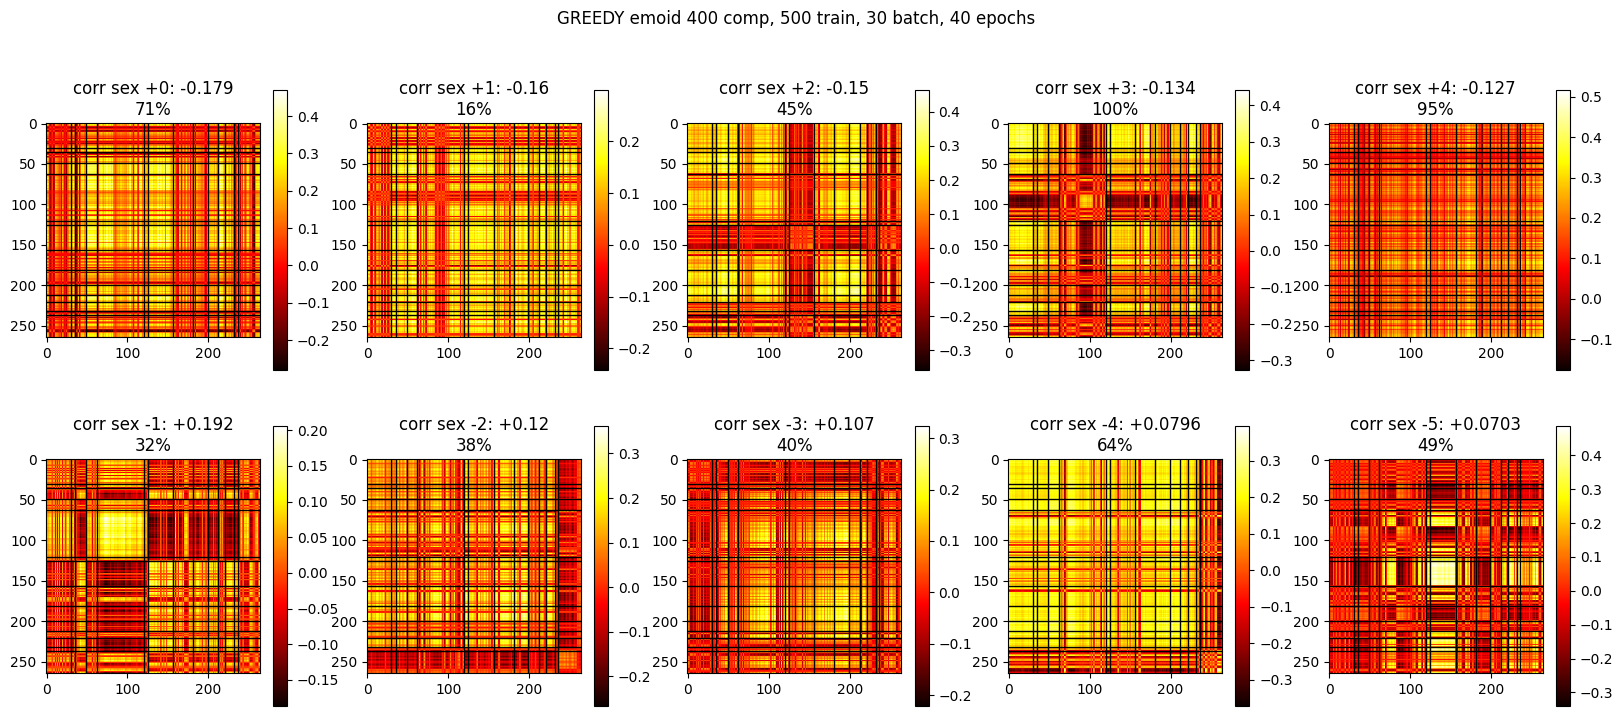

In [80]:
import matplotlib as mpl

fig,ax = plt.subplots(2,5,figsize=(20,8))

# codesmumu = torch.mean(torch.abs(codesmu), dim=0)
m = torch.max(codesmumu)

for high in range(2):
    for idx in range(5):
        rank = idx if high == 0 else -idx-1
        myidx = greedyn[idx] if high == 0 else greedyp[idx] 
        mycorr = greedycn[idx] if high == 0 else greedycp[idx]
        img = book[myidx].detach().cpu().numpy()
        im = ax[high,idx].imshow(remap(img/np.abs(img)*np.abs(img)**0.5), cmap='hot')
        fig.colorbar(mappable=im, ax=ax[high,idx])
        for e in comm_edges:
            ax[high,idx].plot((0,263),(e,e),color='black',linewidth=1)
            ax[high,idx].plot((e,e),(0,263),color='black',linewidth=1)
        ax[high,idx].set_title(f'\ncorr {field} {rank:+d}: {mycorr:+.3}\n{codesmumu[myidx]/m*100:.0f}%')

fig.suptitle(f'GREEDY {mod} {ncodes} comp, {ntrain} train, {nbatch} batch, {nEpochs} epochs')        
# fig.savefig(f'../../Work/LatSimEC/FigureAgeNetworks/age-800-idx{idx:+d}.pdf')
fig.show()

/tmp/ipykernel_18528/3282917551.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


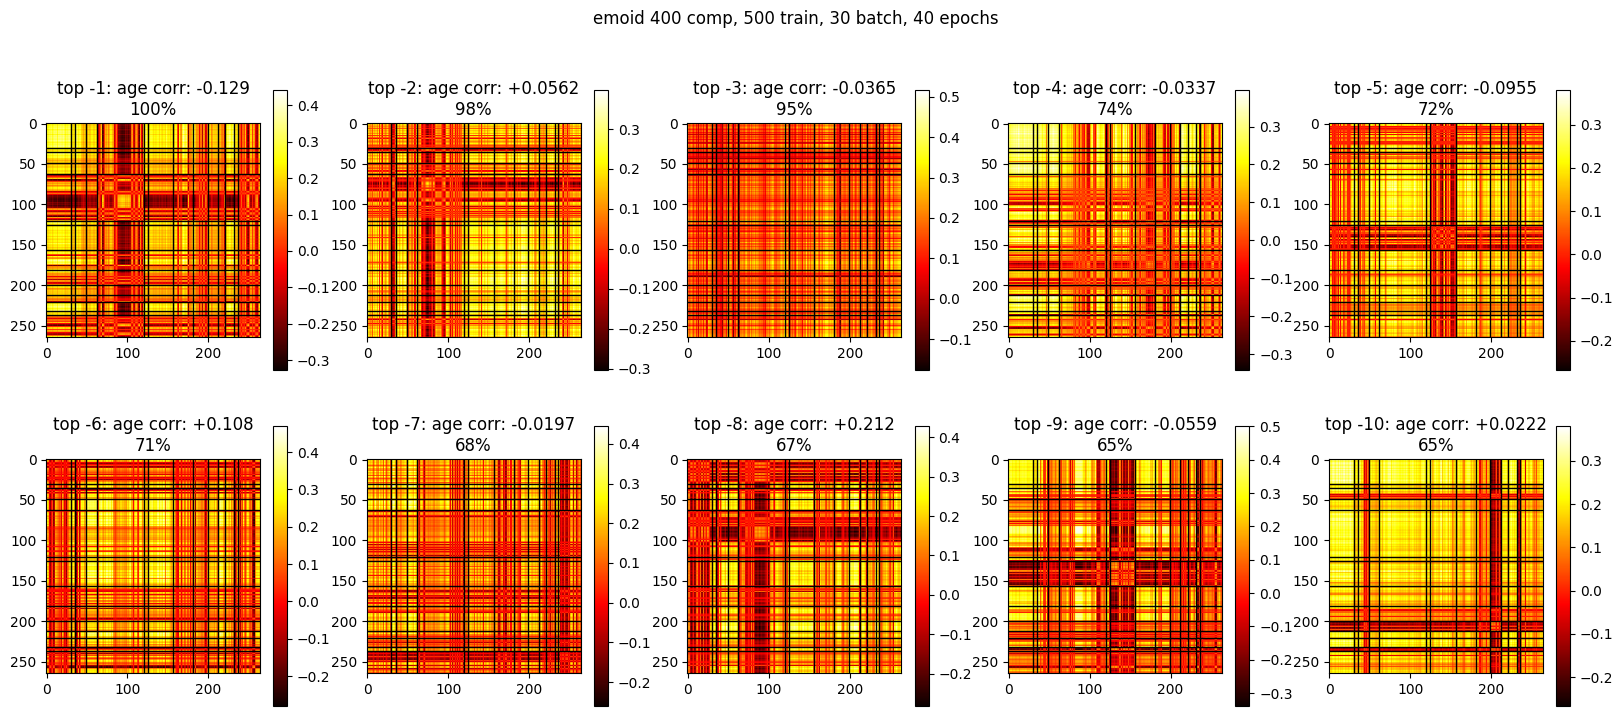

In [76]:
import matplotlib as mpl

fig,ax = plt.subplots(2,5,figsize=(20,8))

# codesmumu = torch.mean(torch.abs(codesmu), dim=0)
m = torch.max(codesmumu)

for idx in range(10):
    high = int(idx/5)
    myidx = -idx-1
    img = book[idcs2[myidx]].detach().cpu().numpy()
    im = ax[high,idx%5].imshow(remap(img/np.abs(img)*np.abs(img)**0.5), cmap='hot')
    fig.colorbar(mappable=im, ax=ax[high,idx%5])
    for e in comm_edges:
        ax[high,idx%5].plot((0,263),(e,e),color='black',linewidth=1)
        ax[high,idx%5].plot((e,e),(0,263),color='black',linewidth=1)
    ax[high,idx%5].set_title(f'\ntop {myidx:+d}: {field} corr: {corr[idcs2[myidx]]:+.3}\n{codesmumu[idcs2[myidx]]/m*100:.0f}%')

fig.suptitle(f'{mod} {ncodes} comp, {ntrain} train, {nbatch} batch, {nEpochs} epochs')            
# fig.savefig(f'../../Work/LatSimEC/FigureAgeNetworks/age-800-idx{idx:+d}.pdf')
fig.show()

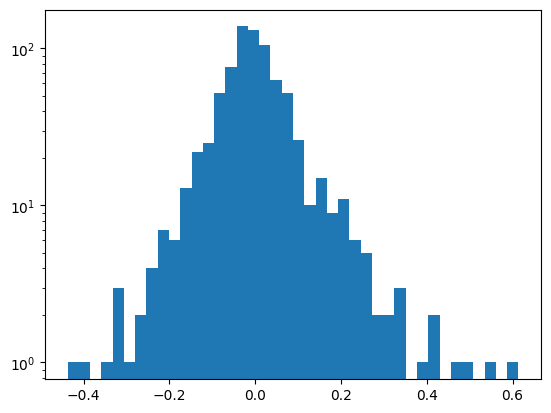

In [37]:
plt.hist(corr.detach().numpy(), bins=40, log=True)
plt.show()

In [26]:
# Show original correlations

p = np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(X[2])])
print(p.shape)

(830, 34716)


In [38]:
y = get_y(metadict, ['age'], subs)[0]
yt = torch.from_numpy(y).float()
x1 = znorm(torch.from_numpy(p).float())
x2 = znorm(yt)
corr = torch.einsum('nd,n->d',x1,x2)
corr /= torch.std(x2)
corr /= x1.shape[0]
print(corr.shape)
print(max(corr))
print(min(corr))

torch.Size([34716])
tensor(0.4614)
tensor(-0.3814)


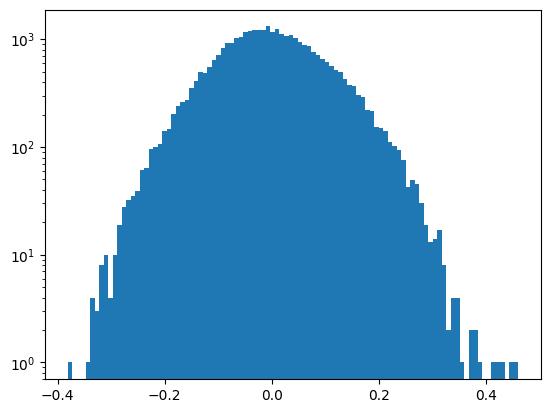

In [39]:
plt.hist(corr.detach().cpu().numpy(), bins=100, log=True)
plt.show()